# Nasa_Defects - 02 - Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, precision_recall_curve, auc
from IPython.display import display, Markdown
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "Nasa"

ROOT = "./"
COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"

DEBUG = False
SEED = 666

In [2]:
if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(d): os.makedirs(d)
  if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

### Dataset

In [3]:
df = pd.read_pickle(ROOT+"data/cleaned.pkl")
print(df.shape)
df.head(1)

(8250, 22)


,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL,label
0,447.0,826.0,12.0,157.0,470.0,385.0,113.0,2824.0,210.28,384.45,31079782.27,26.95,8441.0,0.0,1726654.57,80843.08,3021.0,5420.0,609.0,155.0,3442.0,1


In [4]:
# Separate features and target column
target_column = 'label'
features = df.drop(columns=[target_column])
target = df[target_column]

In [5]:
# Define the classifier
classifier = RandomForestClassifier(random_state=42)

In [6]:
# Use StratifiedKFold for cross-validation on an imbalanced dataset
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Apply SMOTE for oversampling to handle class imbalance
smote = SMOTE(random_state=42)
features_resampled, target_resampled = smote.fit_resample(features, target)


In [8]:
# Evaluate the model using cross-validation and precision-recall AUC
precision_recall_auc_scores = cross_val_score(classifier, features_resampled, target_resampled, cv=cv, scoring='average_precision')

In [9]:
print(f"Average PR AUC: {precision_recall_auc_scores.mean()}")

Average PR AUC: 0.9195079846406141


In [10]:
models = {
        "DT": DecisionTreeClassifier(),
        "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
        "KNN": KNeighborsClassifier(),
        "SVC": SVC(),
        "RF": RandomForestClassifier(),
    }

In [12]:
def train_models(features, target):
    

    for name, model in models.items():
        cv = 10  # Number of cross-validation folds
        precision_recall_auc_scores = cross_val_score(model, features, target, cv=cv, scoring='average_precision')
        mean_pr_auc = precision_recall_auc_scores.mean()
        std_pr_auc = precision_recall_auc_scores.std()

        print(f"\nModel: {name}")
        print(f"\tPR AUC scores: {precision_recall_auc_scores}")
        print(f"\tMean PR AUC: {mean_pr_auc:.4f}, Std: {std_pr_auc:.4f}")

# Assuming features and target are your feature matrix and target variable
train_models(features_resampled, target_resampled)


Model: DT
	PR AUC scores: [0.57676537 0.5439453  0.5500096  0.73282433 0.75293633 0.77935661
 0.74757573 0.76135095 0.74499699 0.77974267]
	Mean PR AUC: 0.6970, Std: 0.0930

Model: DT(max_depth=3)
	PR AUC scores: [0.63098351 0.57494628 0.57517005 0.71695546 0.74366501 0.75826971
 0.69275725 0.7572865  0.77260804 0.7422841 ]
	Mean PR AUC: 0.6965, Std: 0.0720

Model: KNN
	PR AUC scores: [0.69982894 0.66351962 0.6635136  0.73044082 0.7590381  0.75580198
 0.74482839 0.78481538 0.75473411 0.74501121]
	Mean PR AUC: 0.7302, Std: 0.0391

Model: SVC
	PR AUC scores: [0.63899343 0.53499254 0.57619649 0.67329049 0.60423448 0.66502482
 0.57503696 0.69284854 0.62015277 0.55982281]
	Mean PR AUC: 0.6141, Std: 0.0502

Model: RF
	PR AUC scores: [0.81772358 0.69179239 0.69195991 0.93659417 0.98399532 0.98136776
 0.95892786 0.97512342 0.96937006 0.98709544]
	Mean PR AUC: 0.8994, Std: 0.1140


RandomForest model has the best accuracy

Checks feature importance on multiple models.

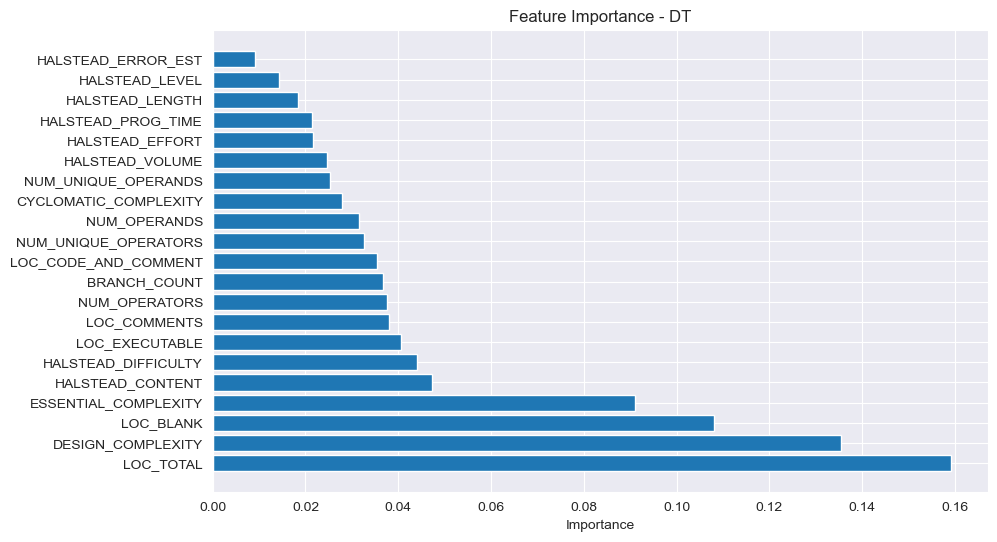

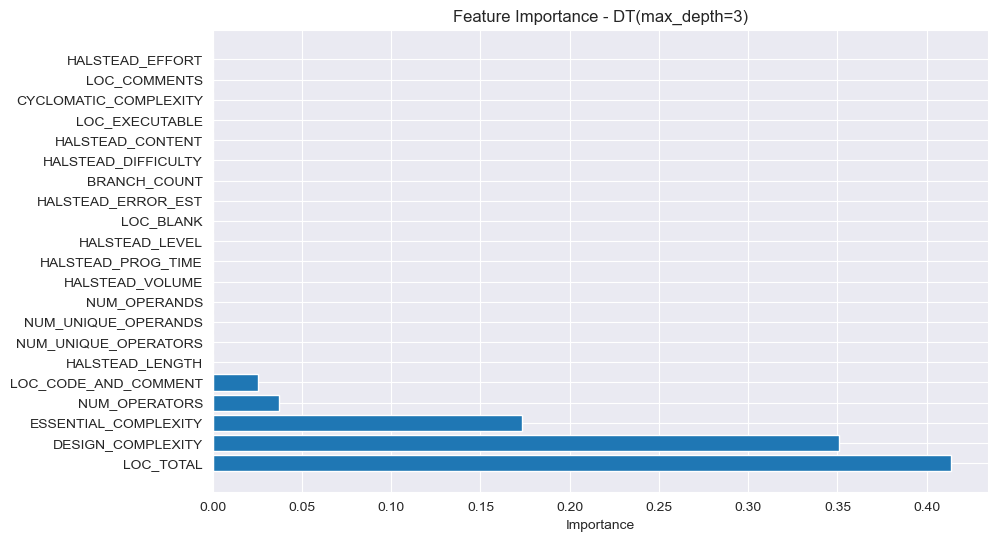

Model 'KNN' does not provide feature importances.
Model 'SVC' does not provide feature importances.


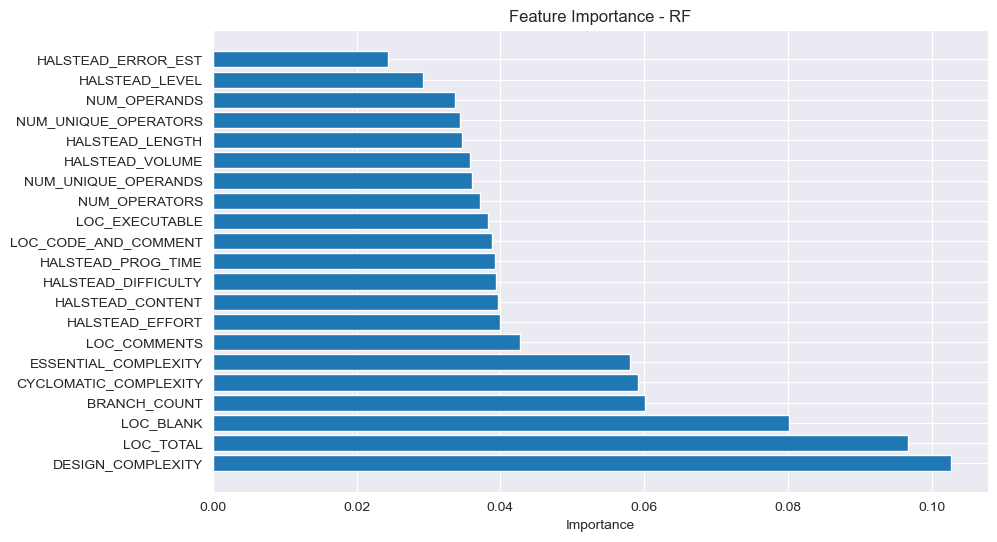

In [11]:
# Iterate through the models
for name, model in models.items():
    # Fit the model on the entire dataset for feature importance
    model.fit(features_resampled, target_resampled)

    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For models like Logistic Regression
        feature_importances = model.coef_[0]
    else:
        # For models without feature importances (e.g., KNN, SVC)
        print(f"Model '{name}' does not provide feature importances.")
        continue

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {name}')
    plt.show()